In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', origin='lower')
plt.rc('figure', figsize=(10, 6))
# plt.rc('text', usetex=False)
# plt.rc('xtick', labelsize=20)
# plt.rc('ytick', labelsize=20)

In [2]:
import pandas as pd
import numpy as np
import astropy.units as u

## Read data as pd DataFrame

In [3]:
with open('../Astr511HW1data.dat', 'r') as ff:
    line1 = ff.readline()
    cols = line1.strip('#').split()

df = pd.read_csv('../Astr511HW1data.dat', comment='#', delim_whitespace=True, names=cols)

In [4]:
len(df)

576801

In [5]:
df.head()

,ra,dec,run,Ar,u,g,r,i,z,uErr,gErr,rErr,iErr,zErr,pmL,pmB,pmErr
0,181.61220,27.57260,5087,0.05,16.40,15.24,14.80,14.73,14.69,0.02,0.02,0.02,0.02,0.01,5.16,-1.45,2.72
1,181.61303,27.60770,5087,0.05,21.84,19.55,18.40,18.04,17.79,0.18,0.02,0.02,0.02,0.02,5.48,4.73,3.16
2,181.61416,27.35956,5112,0.05,19.76,17.56,16.61,16.23,16.07,0.03,0.01,0.02,0.03,0.03,3.14,7.92,2.79
3,181.61640,27.82464,5112,0.06,21.73,20.63,20.19,19.99,20.04,0.16,0.03,0.03,0.03,0.13,19.13,-1.08,5.08
4,181.62112,28.01623,5087,0.05,21.37,20.38,20.11,20.05,19.87,0.11,0.04,0.03,0.03,0.09,-3.65,-8.00,4.91


## Calculate Metalliticites Fe/H

\begin{equation}
[Fe/H] = A + Bx + Cy + Dxy + Ex^2 + Fy^2 + Gx^2y + Hxy^2 + Ix^3 + Jy^3
\end{equation}
$x = (u - g) \\
y = (g - r) \\
(A - J) = (-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20)$

In [6]:
df['x'] = df['u'] - df['g']
df['y'] = df['g'] - df['r']

coeff = (-13.13, 14.09, 28.04, -5.51, -5.90, -58.68, 9.14, -20.61, 0.0, 58.20)
A, B, C, D, E, F, G, H, I, J = coeff

metallicity = lambda x, y: A + B*x + C*y + D*x*y + E*x**2 + F*y**2 + G*x**2*y + H*x*y**2 + I*x**3 + J*y**3

df['Fe/H'] = -0.6
df.loc[(df['y'] < 0.6), 'Fe/H'] = metallicity(df.loc[(df['y'] < 0.6), 'x'], df.loc[(df['y'] < 0.6), 'y'])

## Calculate Absolute Mag in r from Fe/H and g - r

#### Fiducial Abs Mag in r $M^0_r$
A7
\begin{equation}
M^0_r (g - i) = -5.06 + 14.32x - 12.97x^2 + 6.127x^3 - 1.267x^4 + 0.0967x^5
\end{equation}

#### Metalicity Correction $\Delta M_r$
A2
\begin{equation}
\Delta M_r([Fe/H]) = 4.50 - 1.11 [Fe/H] - 0.18[Fe/H]^2
\end{equation}

#### Fitted Abs Mag in r $M_r$
A3
\begin{equation}
M_r(g - i, [Fe/H]) = M^0_r (g - i) + \Delta M_r([Fe/H])
\end{equation}




In [7]:
# A2
df['DelMr'] = 4.50 - 1.11 * df['Fe/H'] - 0.18 * df['Fe/H'] ** 2

# A7
fiducial_M_r = lambda x: -5.06 + 14.32*x - 12.97*x**2 + 6.127*x**3 - 1.267*x**4 + 0.0967*x**5
df['FidcMr'] = fiducial_M_r(df['g'] - df['i'])

# A3
df['Mr'] = df['FidcMr'] + df['DelMr']

## Calculate Z, distance above galactic plane

For distance from galactic plane Z

We assume 

$Z = D$

and 

$r - M_r = 5 * log(D/(10pc))$

Solving for D:

$D = 10^{0.2 * (r - M_r) + 1} pc$


In [8]:
df['Z'] = 10 ** ((df['r'] - df['Mr']) / 5) * 10  # pc
df['Z(kpc)'] = df['Z'] / 1000

## Problem 1
For stars with $0.2 < g - r < 0.4$, plot $ln(\rho)$ vs. $Z$ where $\rho$ is the stellar number density in a given bin, Approximate 

$\rho(Z) = N(Z) / V(Z)$

where N is the number of stars in a given bin, V is the bin volume.

In [9]:
gr24 = df.loc[((df['g'] - df['r']) < 0.4) & ((df['g'] - df['r']) > 0.2)]

In [10]:
sa = (314 * u.deg **2).to(u.sr).value

In [11]:
def get_vol_elements(n, bin_size, bin_start, solid_angle, method='avg', disp=False):
    def puck_vol(distance, sa, thickness):
        return sa * distance ** 2 * thickness
    def cone_vol(distance, sa):
        return 1/3 * distance ** 3 * sa 
    
    lower_bound = np.arange(bin_start, round(bin_size * n + bin_start, 6), bin_size)
    upper_bound = np.arange(bin_start + bin_size, round(bin_size * (n + 1) + bin_start, 6), bin_size)
    lower_bound = np.round(lower_bound, 6)
    upper_bound = np.round(upper_bound, 6)
    
    
    if method == 'avg':
        dVs =  0.5 * (puck_vol(lower_bound, solid_angle, bin_size) + 
                      puck_vol(upper_bound, solid_angle, bin_size))
        
    elif method == 'lower':
        dVs = puck_vol(lower_bound, solid_angle, bin_size)
            
    elif method == 'upper':
        dVs = puck_vol(upper_bound, solid_angle, bin_size)
        
    elif method == 'exact':
        dVs = cone_vol(upper_bound, solid_angle) - cone_vol(lower_bound, solid_angle)
    
    if disp:
        for ii in range(n):
            print(f'from {lower_bound[ii]} to {upper_bound[ii]}:\t {dVs[ii]}')
    
    return dVs
    
    


In [12]:
(get_vol_elements(40, 0.4, 0.8, sa, 'exact') / get_vol_elements(40, 0.4, 0.8, sa, 'avg'))

array([0.97435897, 0.98666667, 0.99186992, 0.99453552, 0.99607843,
       0.99705015, 0.99770115, 0.99815838, 0.9984917 , 0.99874214,
       0.99893504, 0.99908676, 0.99920823, 0.999307  , 0.99938838,
       0.99945623, 0.99951338, 0.99956198, 0.99960365, 0.99963964,
       0.99967094, 0.99969834, 0.99972245, 0.99974379, 0.99976275,
       0.99977969, 0.99979487, 0.99980854, 0.99982088, 0.99983207,
       0.99984225, 0.99985152, 0.99986   , 0.99986778, 0.99987492,
       0.9998815 , 0.99988758, 0.9998932 , 0.9998984 , 0.99990324])

In [13]:
def get_star_counts(distance_arr, n, bin_size, bin_start, disp_table=False):
    bounds =  np.arange(bin_start, round(bin_size * (n + 1) + bin_start, 6), bin_size)
    bounds = np.round(bounds, 6)
    counts, bins = np.histogram(distance_arr, bins=bounds)
    if disp_table:
        for ii in range(n):
            print(f'from {bounds[ii]} to {bounds[ii+1]}:\t {counts[ii]}')
    return counts
    

In [14]:
get_star_counts(gr24['Z(kpc)'], 20, .4, .8, disp_table=True)

from 0.8 to 1.2:	 2102
from 1.2 to 1.6:	 3235
from 1.6 to 2.0:	 3409
from 2.0 to 2.4:	 3307
from 2.4 to 2.8:	 3194
from 2.8 to 3.2:	 2879
from 3.2 to 3.6:	 2792
from 3.6 to 4.0:	 2640
from 4.0 to 4.4:	 2657
from 4.4 to 4.8:	 2676
from 4.8 to 5.2:	 2590
from 5.2 to 5.6:	 2687
from 5.6 to 6.0:	 2713
from 6.0 to 6.4:	 2799
from 6.4 to 6.8:	 2834
from 6.8 to 7.2:	 2804
from 7.2 to 7.6:	 2942
from 7.6 to 8.0:	 2938
from 8.0 to 8.4:	 3050
from 8.4 to 8.8:	 3004


array([2102, 3235, 3409, 3307, 3194, 2879, 2792, 2640, 2657, 2676, 2590,
       2687, 2713, 2799, 2834, 2804, 2942, 2938, 3050, 3004], dtype=int64)

In [84]:
def plot_dens_hist(n, bin_size, bin_start, distance_arr, label, func=np.log, return_vals=False):
    sa = (314 * u.deg **2).to(u.sr).value
    V = get_vol_elements(n, bin_size, bin_start, sa)
    N = get_star_counts(distance_arr, n, bin_size, bin_start)
    bounds =  np.arange(bin_start, round(bin_size * n + bin_start, 6), bin_size)
    bounds = np.round(bounds, 6)
    plt.step(bounds, func(N/V), label=label)
    if return_vals == True:
        return bounds, N, N/V


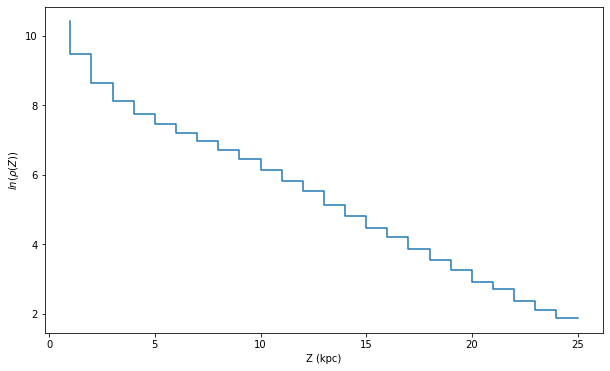

In [16]:
plot_dens_hist(n=25, bin_size=1, bin_start=1, label='', distance_arr=gr24['Z(kpc)'])
plt.xlabel('Z (kpc)')
plt.ylabel(r'$ln(\rho(Z))$')
plt.show()

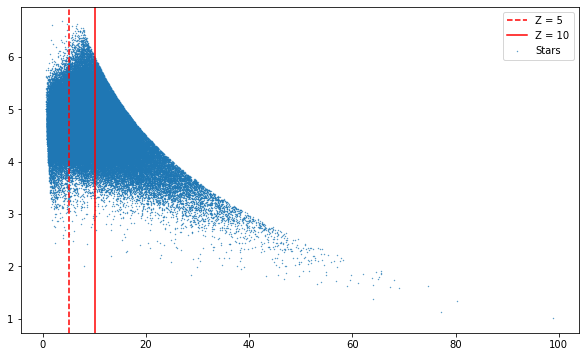

In [17]:
SDSS_maglim=22.5

plt.scatter(gr24['Z(kpc)'], gr24['Mr'], label='Stars', marker='.', s=0.5)
plt.axvline(5, label='Z = 5', color='r', linestyle='--')
plt.axvline(10, label='Z = 10', color='r')
# plt.plot(np.linspace(1, 100, 1001), -5 * np.log(np.linspace(1, 100, 1001)/10) - SDSS_maglim)
plt.legend()

Based on the plot above, we become flux limited at some distance between $Z = 5$ and $Z = 10$. Thus I would only trust our densities for $Z \leq 7$ or so.

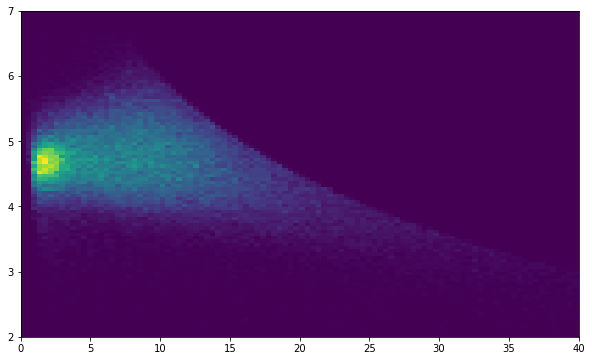

In [29]:
_= plt.hist2d(gr24['Z(kpc)'], gr24['Mr'], label='Stars', bins=100, range=[[0, 40], [2, 7]])

## Problem 2

In [19]:
g_r_bounds = [(round(x, 2), round(x+.2, 2)) for x in np.arange(0.2, 1, 0.2)]

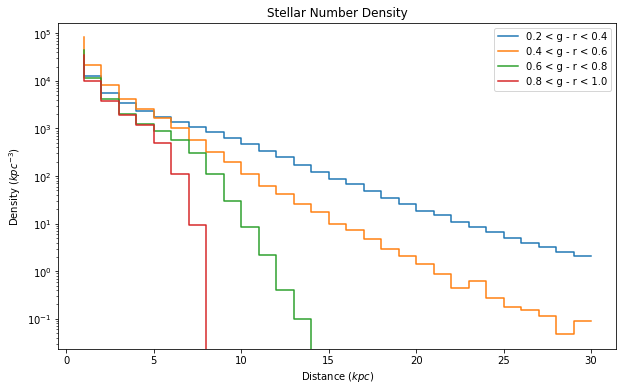

In [20]:
plt.figure()
plt.title('Stellar Number Density')
for lower, upper in g_r_bounds:
    dists = df.loc[((df['g'] - df['r']) < upper) & ((df['g'] - df['r']) > lower), 'Z(kpc)']
    label = f"{lower} < g - r < {upper}"
    plot_dens_hist(n=30, bin_size=1, bin_start=1, distance_arr=dists, label=label, func=lambda x: x)
plt.yscale('log')
plt.xlabel(r'Distance ($kpc$)')
plt.ylabel(r'Density ($kpc^{-3}$)')
plt.legend()
plt.show()

Redder stars (higher g - r values) are generally dimmer. Thus the reddest stars in our sample tend to be the dimmest and we undercount them past 6-7 kpc, as the main sequence stars in those colors become flux-limited.

Our photometric metalicity relation does not work well for very red stars (see Bond et al. 2010). Thus we use \[Fe/H\] = -0.6 for stars redder than g - r > 0.6. This estimate is more precise for stars between 0.6 < g - r < 0.8 than for stars with 0.8 < g - r < 1.0.

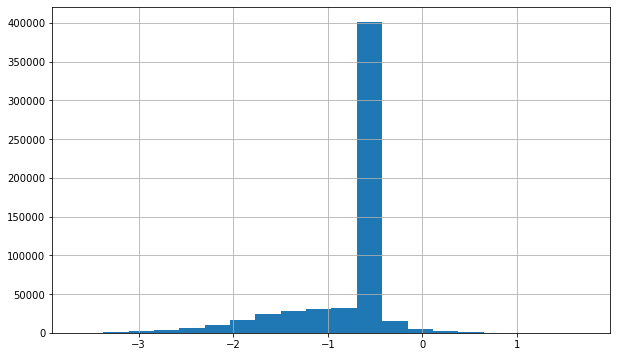

In [38]:
df['Fe/H'].hist(bins=20)

## Problem 3

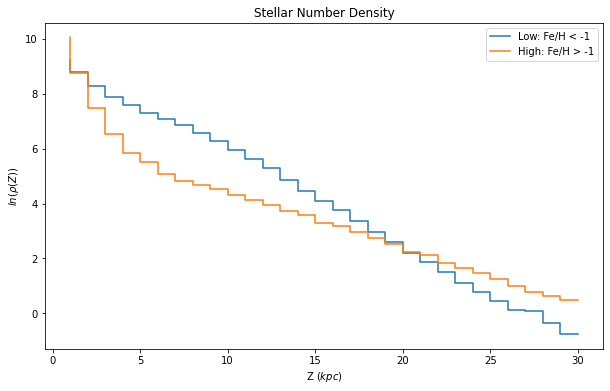

In [21]:
plt.figure()
plt.title('Stellar Number Density')
low_sample = gr24.loc[gr24['Fe/H'] < -1]
high_sample = gr24.loc[gr24['Fe/H'] > -1]

plot_dens_hist(30, 1, 1, low_sample.loc[:, 'Z(kpc)'], 'Low: Fe/H < -1', func=np.log)
plot_dens_hist(30, 1, 1, high_sample.loc[:, 'Z(kpc)'], 'High: Fe/H > -1', func=np.log)
# plt.yscale('log')
plt.xlabel(r'Z ($kpc$)')
plt.ylabel(r'$ln(\rho(Z))$')
plt.legend()
plt.show()

In [22]:
low_sample['g_r'] = low_sample['g'] - low_sample['r']
high_sample['g_r'] = high_sample['g'] - high_sample['r']

<ipython-input-22-7681d702a684>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_sample['g_r'] = low_sample['g'] - low_sample['r']
<ipython-input-22-7681d702a684>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_sample['g_r'] = high_sample['g'] - high_sample['r']


In [23]:
# low_sample.loc[low_sample['Z(kpc)'] > 10, 'Mr'].hist(label='low')
# high_sample.loc[high_sample['Z(kpc)'] > 10, 'Mr'].hist(alpha=.5, label='high')
# plt.legend()

In [24]:
# low_sample.loc[low_sample['Z(kpc)'] > 20, 'g_r'].hist(label='low')
# high_sample.loc[high_sample['Z(kpc)'] > 20, 'g_r'].hist(alpha=.5, label='high')


In [25]:
# low_sample.loc[low_sample['Z(kpc)'] > 30, 'g_r'].hist(label='low')
# high_sample.loc[high_sample['Z(kpc)'] > 30, 'g_r'].hist(alpha=.5, label='high')
# plt.legend()

## Problem 4

In [26]:
low_counts, low_Mr = np.histogram(low_sample['r'], bins=np.linspace(14,21, 29))
high_counts, high_Mr = np.histogram(high_sample['r'], bins=np.linspace(14, 21, 29))

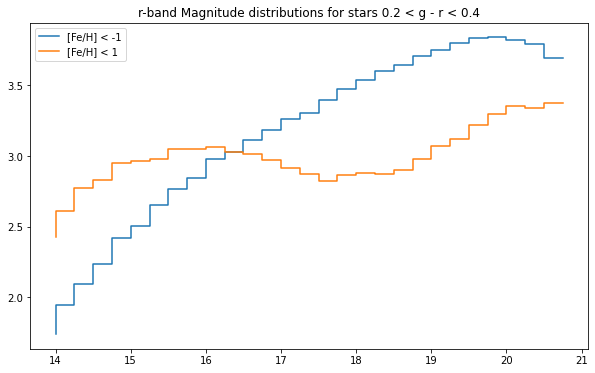

In [27]:
plt.title('r-band Magnitude distributions for stars 0.2 < g - r < 0.4')
plt.step(low_Mr[:-1], np.log10(low_counts), label='[Fe/H] < -1')
plt.step(high_Mr[:-1], np.log10(high_counts), label='[Fe/H] < 1')
plt.legend()

## Problem 5

Steps for estimating stars with 0.2 < g - r < 0.4 at 90-100kpc:

1. Determine distance (upper bound on Z) at which stars in this band become flux limited
2. Determine distance that we begin to be dominated by halo stars (lower bound on Z)
3. Calculate distance from the galactic center assuming we are 8.0kpc from the center and using the Pythagorian Theorem: $R^ 2 = (8.0 kpc)^2 + Z^2$
4. Fit distance, density relation with a $\rho \propto \frac{1}{R^3}$ relation.
5. Use the fit to extrapolate to distances between 90 and 100 kpc.

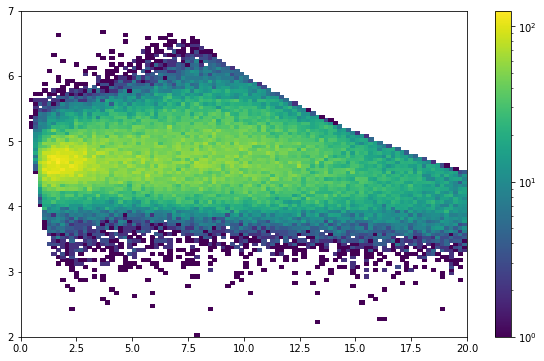

In [41]:
from matplotlib.colors import LogNorm
h = plt.hist2d(gr24['Z(kpc)'], gr24['Mr'], label='Stars', bins=100, norm=LogNorm(), range=[[0, 20], [2, 7]])
plt.colorbar(h[3])

It appears flux limiting occurs around Z~7

Additionally, we set Z ~ 4 to be the edge of the disk (See appendix A)

In [341]:
Z_min, Z_max = 4, 7
non_limited = gr24.loc[(gr24['Z(kpc)'] > Z_min) & (gr24['Z(kpc)'] < Z_max)]
non_limited['R_gc'] = np.sqrt(non_limited['Z(kpc)'] ** 2 + 8.0 ** 2)

# print(non_limited['R_gc'].min(), non_limited['R_gc'].max())
# Rmin, Rmax = non_limited['R_gc'].min(), non_limited['R_gc'].max()

<ipython-input-341-918f1f72bd21>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_limited['R_gc'] = np.sqrt(non_limited['Z(kpc)'] ** 2 + 8.0 ** 2)


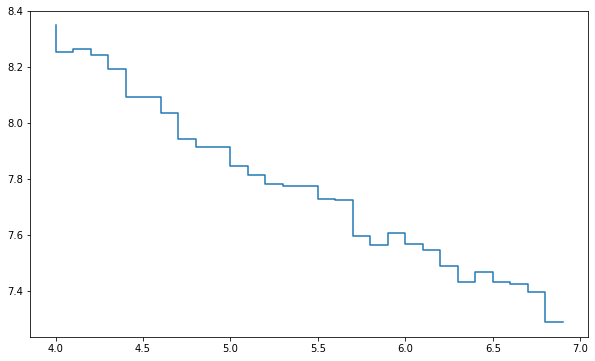

In [342]:
nsteps = 30
step_size = (Z_max - Z_min)/nsteps
dist_Z, num, dens = plot_dens_hist(nsteps, step_size, Z_min, non_limited['Z(kpc)'], label='', return_vals=True)

In [343]:
def R_to_Z(R):
    # pdb.set_trace()
    R = np.array([max(x, 8) for x in R])
    Z2 = np.array([R ** 2 - 8 ** 2])
    return np.sqrt(Z2)[0]

def Z_to_R(Z):
    return np.sqrt(Z ** 2 + 8 ** 2)

In [344]:
dist_R = Z_to_R(dist_Z)
dist_R

array([ 8.94427191,  8.98943825,  9.0354856 ,  9.08240056,  9.13016977,
        9.17877988,  9.2282176 ,  9.2784697 ,  9.32952303,  9.38136451,
        9.43398113,  9.48736001,  9.54148835,  9.59635347,  9.65194281,
        9.70824392,  9.76524449,  9.82293235,  9.88129546,  9.94032193,
       10.        , 10.06031809, 10.12126474, 10.18282868, 10.24499878,
       10.30776406, 10.37111373, 10.43503713, 10.4995238 , 10.56456341])

In [354]:
from scipy.optimize import curve_fit

def f1(r, A, n):
    return A / r ** n

def f2(r, A, b, r0):
    return A * np.exp(-b * (r - r0))

# def f3 (r, A, n, b, r0):
#     return 

halo_mask = [dist_Z > 4]

param_f1, _ = curve_fit(f1, dist_R[halo_mask], dens[halo_mask])

<ipython-input-354-a1b4c660bd1c>:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  param_f1, _ = curve_fit(f1, dist_R[halo_mask], dens[halo_mask])


In [355]:
# disk_mask = [dist_Z < 3]
# param_f2, _ = curve_fit(f2, dist_R[disk_mask], dens[disk_mask])

<Figure size 720x432 with 0 Axes>

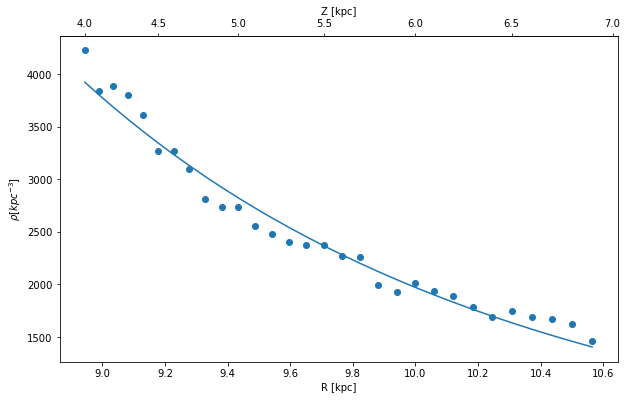

<Figure size 720x432 with 0 Axes>

In [359]:
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
import pdb


extr = np.linspace(9, 50, 92)

ax = plt.subplot()
ax.scatter(dist_R, dens)
ax.plot(dist_R, f1(dist_R, *param_f1))
# ax.plot(dist_R, f2(dist_R, *param_f2))
# ax.plot(dist_R, f1(dist_R, *param_f1) + f2(dist_R, *param_f2))
# ax.plot(extr, f1(extr, *param_f1))
# ax.plot(extr, f2(extr, *param_f2))
secax = ax.secondary_xaxis('top', functions=(R_to_Z, Z_to_R))
# ax.set_xlim([90,100])
# ax.set_ylim([0, .0001])
ax.set_xlabel('R [kpc]')
ax.set_ylabel(r'$\rho  [kpc^{-3}]$')
secax.set_xlabel('Z [kpc]')

plt.figure()
# plt.plot(dist, f2(dist, *param_f2))

In [369]:
sum(f1(np.linspace(90, 100, 10), *param_f1) * get_vol_elements(10, 1, 90, (1 * u.deg **2).to(u.sr).value)

0.05120450142200082

So there is about a 1/20 chance of finding a star between 90 kpc and 100 kpc

## Appendix A

In [370]:
Z_min, Z_max = 1, 7
non_limited = gr24.loc[(gr24['Z(kpc)'] > Z_min) & (gr24['Z(kpc)'] < Z_max)]
non_limited['R_gc'] = np.sqrt(non_limited['Z(kpc)'] ** 2 + 8.0 ** 2)

<ipython-input-370-6eedf4ecde31>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_limited['R_gc'] = np.sqrt(non_limited['Z(kpc)'] ** 2 + 8.0 ** 2)


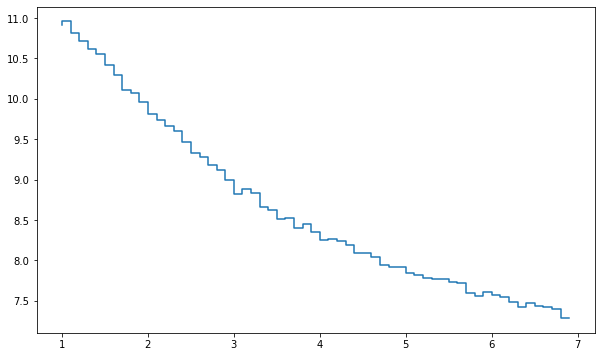

In [372]:
nsteps = 60
step_size = (Z_max - Z_min)/nsteps
dist_Z, num, dens = plot_dens_hist(nsteps, step_size, Z_min, non_limited['Z(kpc)'], label='', return_vals=True)
dist_R = Z_to_R(dist_Z)


In [373]:
def f1(r, A, n):
    return A / r ** n

def f2(r, A, b, r0):
    return A * np.exp(-b * (r - r0))

halo_mask = [dist_Z > 4]

param_f1, _ = curve_fit(f1, dist_R[halo_mask], dens[halo_mask])

disk_mask = [dist_Z < 3]
param_f2, _ = curve_fit(f2, dist_R[disk_mask], dens[disk_mask])

<ipython-input-373-3c9f414fdd12>:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  param_f1, _ = curve_fit(f1, dist_R[halo_mask], dens[halo_mask])
<ipython-input-373-3c9f414fdd12>:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  param_f2, _ = curve_fit(f2, dist_R[disk_mask], dens[disk_mask])


<Figure size 720x432 with 0 Axes>

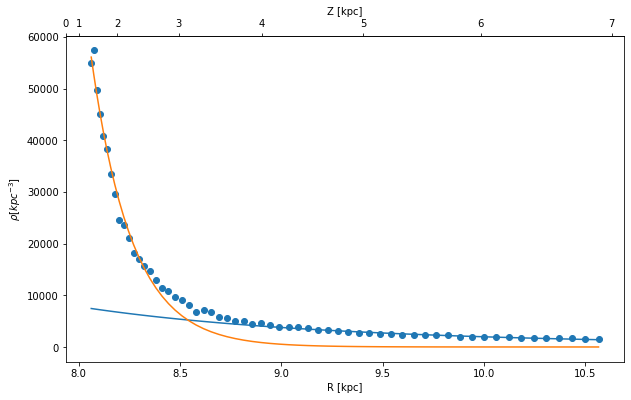

<Figure size 720x432 with 0 Axes>

In [376]:
extr = np.linspace(9, 50, 92)

ax = plt.subplot()
ax.scatter(dist_R, dens)
ax.plot(dist_R, f1(dist_R, *param_f1))
ax.plot(dist_R, f2(dist_R, *param_f2))
# ax.plot(dist_R, f1(dist_R, *param_f1) + f2(dist_R, *param_f2))

secax = ax.secondary_xaxis('top', functions=(R_to_Z, Z_to_R))
ax.set_xlabel('R [kpc]')
ax.set_ylabel(r'$\rho  [kpc^{-3}]$')
secax.set_xlabel('Z [kpc]')

plt.figure()
# plt.plot(dist, f2(dist, *param_f2))

<ipython-input-378-46471079cd86>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax.semilogy(dist_R[disk_mask], f2(dist_R[disk_mask], *param_f2))


<Figure size 720x432 with 0 Axes>

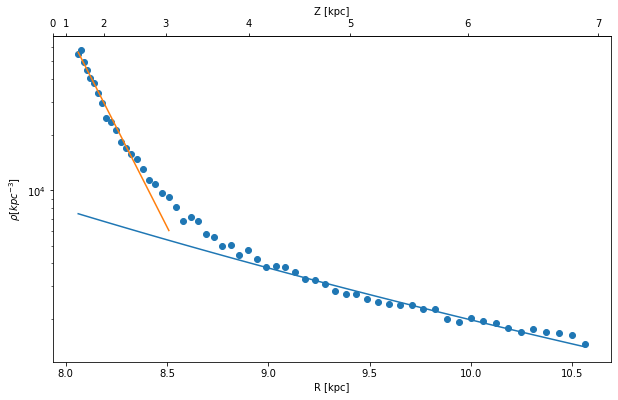

<Figure size 720x432 with 0 Axes>

In [378]:
extr = np.linspace(9, 50, 92)

ax = plt.subplot()
ax.scatter(dist_R, dens)
ax.semilogy(dist_R, f1(dist_R, *param_f1))
ax.semilogy(dist_R[disk_mask], f2(dist_R[disk_mask], *param_f2))
# ax.plot(dist_R, f1(dist_R, *param_f1) + f2(dist_R, *param_f2))

secax = ax.secondary_xaxis('top', functions=(R_to_Z, Z_to_R))
ax.set_xlabel('R [kpc]')
ax.set_ylabel(r'$\rho  [kpc^{-3}]$')
secax.set_xlabel('Z [kpc]')

plt.figure()
# plt.plot(dist, f2(dist, *param_f2))

# Ignore after this point

#### Trying density function from the paper

In [292]:
Z_sun = 25  # pc
R_sun = 8000  #pc
H1 = 245  # pc
H2 = 743  # pc
e_D = .13
e_H = 0.0051
q_H = 0.64
n_H = 2.77
L1 = 2150
L2 = 3261
rho_D0 = 560440   # counts / kpc^3     

def rho_D(R):
    Z = np.sqrt(R ** 2 - 8000 ** 2)
    return rho_D0 * (np.exp(-np.abs(Z + Z_sun)/H1 - (R-R_sun)/L1) + e_D * np.exp(-np.abs(Z + Z_sun) / H2 - (R - R_sun) / L2)) 

def rho_H(R):
    Z = np.sqrt(R ** 2 - 8000 ** 2)
    return (rho_D0 * e_H * (R_sun ** 2 / (R ** 2 + (Z/q_H))) ** (n_H / 2))
    

<ipython-input-292-6e2f5cec86d5>:14: RuntimeWarning: invalid value encountered in sqrt
  Z = np.sqrt(R ** 2 - 8000 ** 2)
<ipython-input-292-6e2f5cec86d5>:18: RuntimeWarning: invalid value encountered in sqrt
  Z = np.sqrt(R ** 2 - 8000 ** 2)


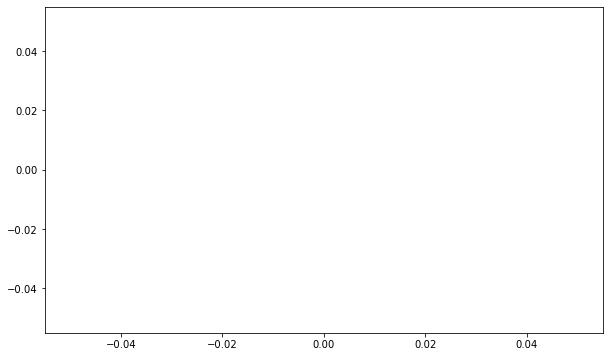

In [298]:
test = np.linspace(8.1, 15, 71)
plt.plot(test, (rho_D(test))/ (rho_D(test) + rho_H(test)))

<Figure size 720x432 with 0 Axes>

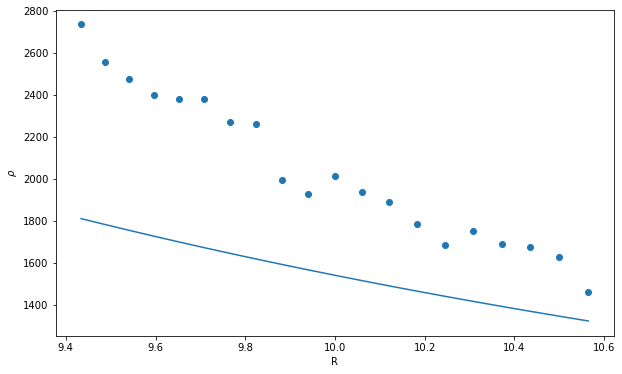

<Figure size 720x432 with 0 Axes>

In [295]:
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
import pdb


extr = np.linspace(9, 100, 92)

ax = plt.subplot()
ax.scatter(dist_R, dens)
# ax.plot(dist_R, f1(dist_R, *param_f1))
# ax.plot(dist_R, f2(dist_R, *param_f2))
# ax.plot(dist_R, rho_D(dist_R*1000))
ax.plot(dist_R, rho_H(dist_R*1000))
ax.set_xlabel('R')
ax.set_ylabel(r'$\rho$')
plt.figure()

In [210]:
np.sqrt(4.5**2 + 64)

9.17877987534291

In [357]:
param_f1

array([2.89301049e+09, 6.16653150e+00])